In [1]:
import networkx as nx
import pandas as pd
#import sys
#!{sys.executable} -m pip install colorgram.py
import colorgram
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import re
from base64 import b16encode
import requests
from io import BytesIO
import urllib.request
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Created a CSV with some other logos
col_names = ['logo_path','team']
Logos = pd.read_csv('https://raw.githubusercontent.com/PLombardo811/620/Project-1/Logos_csv.csv')

In [3]:
logo_path = Logos.logo_path
team = Logos.team
league = Logos.league

In [4]:
colors = []
for i in logo_path:
    URL = urllib.request.urlopen(i)
    colors.append(colorgram.extract(URL,6))

In [5]:
def GetMyColors(color):
   color_return = []
   for each_color in color[:3]:
       color_string = str(each_color.rgb)
       color_int = (re.findall(r'\d+', color_string))
       color_return.append(color_int)
   return(color_return)

In [6]:
team_colors = {}
for i in list(range(len(team))):
    team_colors[team[i]] = GetMyColors(colors[i])

In [7]:
RGBList = []
for i in colors:
   RGBList.append(GetMyColors(i))

In [8]:
df = pd.DataFrame(list(RGBList),columns=["color_1", "color_2", "color_3"]) 
df = df.set_value(25, "color_3", [255,255,255])

In [9]:
top_3_colors = []
for each_column in df.columns.tolist():
    top_3_colors.append([list(map(int, x)) for x in df[each_column]])

hexes = []

def Hex(rgbcolor):
    hex_return = []
    for each_color in rgbcolor:
        hex_color = (b"#" + b16encode(bytes(each_color))).decode()
        hex_return.append(hex_color)
    return(hex_return)

for each_color in top_3_colors:
    hexes.append(Hex(each_color))

In [10]:
df['league'] = league
df['team'] = team_colors
for i in range(3):
    df["hex_"+str(i+1)] = hexes[i]
    df["edges_"+str(i+1)] = df.apply(lambda x: (x["team"], x["hex_"+str(i+1)]), axis=1)
df = df[["team", "league", "color_1", "color_2", "color_3", "hex_1", "hex_2", "hex_3", "edges_1", "edges_2", "edges_3"]]

In [11]:
#G = nx.Graph()
#G.add_edges_from(df["team"].tolist())

In [12]:
unique_colors = list(set(df["hex_1"].tolist() + df["hex_2"].tolist() + df["hex_3"].tolist()))
node_categories = {
    "team": df["team"].tolist(),
    "color": df["hex_1"].tolist() + df["hex_2"].tolist() + df["hex_3"].tolist()
}

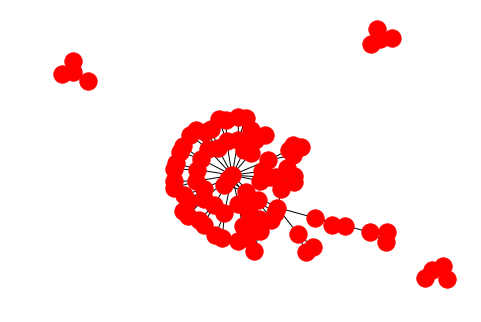

In [13]:
G = nx.Graph()
G.add_edges_from(df["edges_1"].tolist() + df["edges_2"].tolist() + df["edges_3"].tolist())
G.add_nodes_from(df["team"].tolist()+df["hex_1"].tolist() + df["hex_2"].tolist() + df["hex_3"].tolist())
for node in G:
    if node in unique_colors:
        G.node[node]["category"] = "color"
    else:
        G.node[node]["category"] = "team"
nx.draw(G)

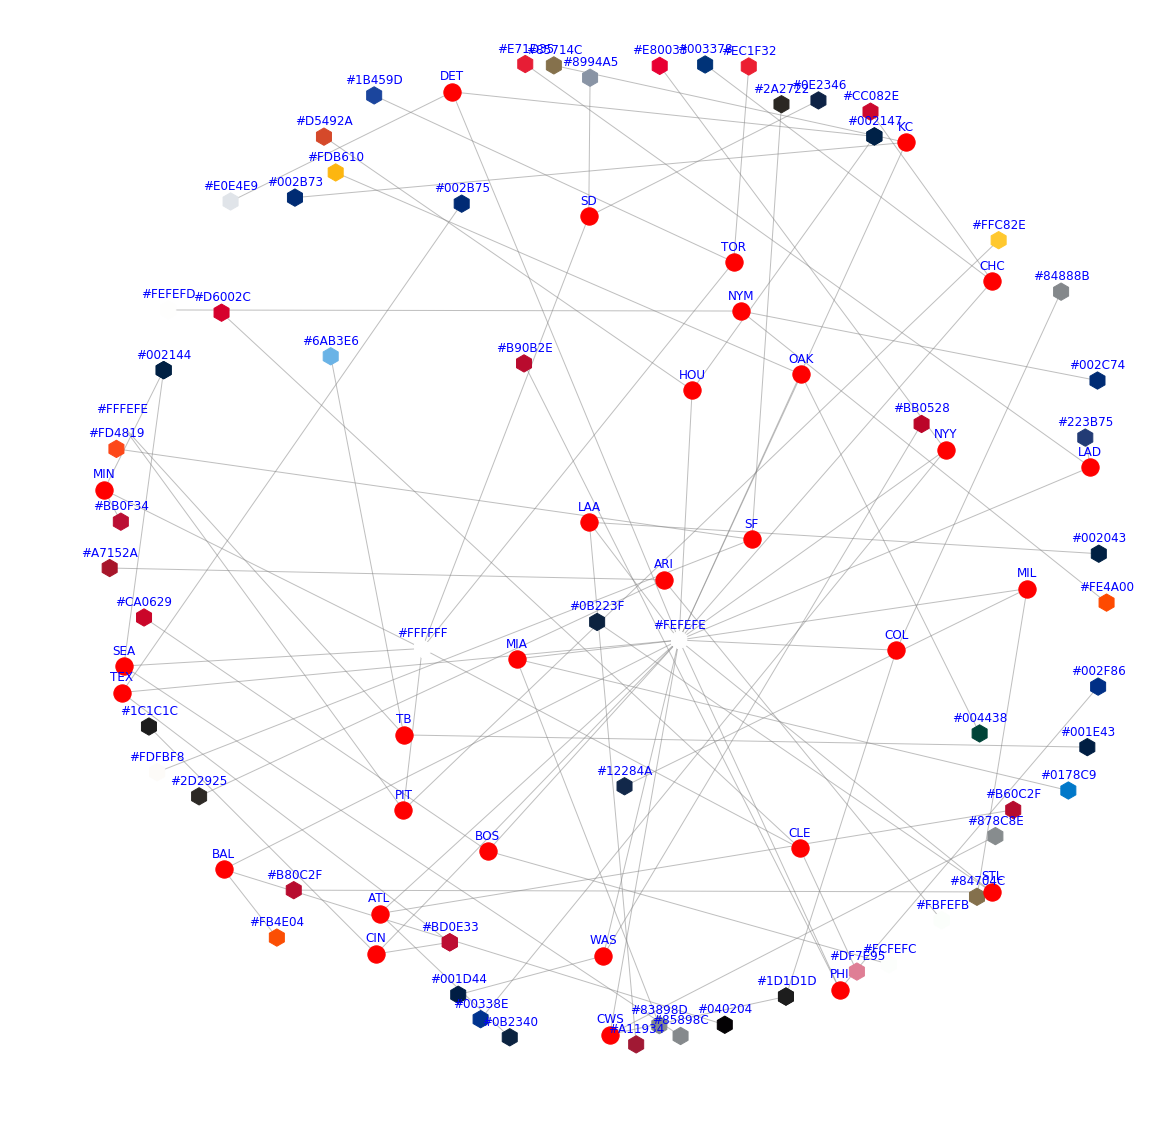

In [14]:
pos = nx.spring_layout(G,k=1.55,iterations=80)
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+0.03)
plt.figure(figsize=(20,20))
nx.draw_networkx_labels(G, pos_labels, font_color='Blue')
nx.draw_networkx_edges(G, pos, edge_color="Gray", alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=node_categories["color"], node_color=[node for node in node_categories["color"]], node_shape="h", node_size=300)
nx.draw_networkx_nodes(G, pos, nodelist=node_categories["team"], node_color="r", node_shape="o", node_size=300)
plt.axis('off')
plt.show()

In [35]:
cf = pd.DataFrame()
cf['eig_centrality'] = nx.eigenvector_centrality(G).values()
cf['deg_centrality'] = nx.degree_centrality(G).values()
cf['bet_centrality'] = nx.betweenness_centrality(G).values()
cf['clo_centrality'] = nx.closeness_centrality(G).values()
cf.index = list(G)
cf

,eig_centrality,deg_centrality,bet_centrality,clo_centrality
NYY,1.556523e-01,0.033333,0.027715,0.247260
#FEFEFE,6.693075e-01,0.222222,0.382022,0.384043
BAL,1.556523e-01,0.033333,0.027715,0.247260
BOS,1.556523e-01,0.033333,0.027715,0.247260
CWS,1.637127e-01,0.033333,0.020599,0.247260
CLE,5.898622e-06,0.033333,0.009238,0.082305
#FFFFFF,1.302575e-05,0.066667,0.039451,0.113960
DET,1.637127e-01,0.033333,0.020599,0.247260
HOU,1.637127e-01,0.033333,0.020599,0.247260
#002147,6.931982e-02,0.022222,0.000499,0.182323
